# Домашнее задание:
1) взять данные отсюда: https://github.com/Laggg/data--for--students (flight_delays.csv)

Задача: научиться предсказывать задержку (столбик *dep_delayed_15min*) рейса по имеющимся данным с помощью Дерева решений (или других алгоритмов).
Это задача бинарной классификации (будет/не будет задержка). Улучшить приведенный пример.

In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')


import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(targets,predictions,classes,
                          normalize=False,title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [76]:
path_to_file = 'flight_delays.csv'
df = pd.read_csv(path_to_file)


df.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [77]:
# Отделим столбик-таргет от признаков:
target = (df['dep_delayed_15min'] == 'Y').astype(int)

df = df.drop(['dep_delayed_15min'], axis=1)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


# Feature engineering

In [78]:
feat = pd.DataFrame(index=df.index)
feat['month'] = df['Month'].apply(lambda x: int(x[2:]))
feat['nday'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
feat['day_week'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

feat['hour'] =  df['DepTime']//100
feat.loc[feat['hour'] == 24, 'hour'] = 0
feat.loc[feat['hour'] == 25, 'hour'] = 1
feat['sin_hour'] = np.sin(2*np.pi*feat['hour']/24)
feat['cos_hour'] = np.cos(2*np.pi*feat['hour']/24)

feat['minute'] =  df['DepTime']%100
feat['sin_min'] = np.sin(2*np.pi*feat['minute']/60)
feat['cos_min'] = np.cos(2*np.pi*feat['minute']/60)

feat['distance'] = df['Distance']
feat['carrier'] = df['UniqueCarrier']
feat['a'] = df['Origin']
feat['b'] = df['Dest']

feat['a-b'] = df['Origin'] + '-' + df['Dest'] # направление

feat.head()

,month,nday,day_week,hour,sin_hour,cos_hour,minute,sin_min,cos_min,distance,carrier,a,b,a-b
0,8,21,7,19,-0.965926,2.588190e-01,34,-0.406737,-9.135455e-01,732,AA,ATL,DFW,ATL-DFW
1,4,20,3,15,-0.707107,-7.071068e-01,48,-0.951057,3.090170e-01,834,US,PIT,MCO,PIT-MCO
2,9,2,5,14,-0.500000,-8.660254e-01,22,0.743145,-6.691306e-01,416,XE,RDU,CLE,RDU-CLE
3,11,25,6,10,0.500000,-8.660254e-01,15,1.000000,2.832769e-16,872,OO,DEN,MEM,DEN-MEM
4,10,7,6,18,-1.000000,-1.836970e-16,28,0.207912,-9.781476e-01,423,WN,MDW,OMA,MDW-OMA


In [79]:
label_enc1 = LabelEncoder()
label_enc2 = LabelEncoder()
label_enc3 = LabelEncoder()
label_enc4 = LabelEncoder()

feat['carrier'] = label_enc1.fit_transform(feat['carrier'])
feat['a'] = label_enc2.fit_transform(feat['a'])
feat['b'] = label_enc3.fit_transform(feat['b'])
feat['a-b'] = label_enc4.fit_transform(feat['a-b'])

feat.head()

,month,nday,day_week,hour,sin_hour,cos_hour,minute,sin_min,cos_min,distance,carrier,a,b,a-b
0,8,21,7,19,-0.965926,2.588190e-01,34,-0.406737,-9.135455e-01,732,0,18,78,152
1,4,20,3,15,-0.707107,-7.071068e-01,48,-0.951057,3.090170e-01,834,18,217,171,3527
2,9,2,5,14,-0.500000,-8.660254e-01,22,0.743145,-6.691306e-01,416,20,228,59,3619
3,11,25,6,10,0.500000,-8.660254e-01,15,1.000000,2.832769e-16,872,15,78,175,1181
4,10,7,6,18,-1.000000,-1.836970e-16,28,0.207912,-9.781476e-01,423,19,174,199,2681


Общее число совпадений 0.727
Полнота охвата класса 1: 0.329
Точность: 0.306
ROC_AUC: 0.575


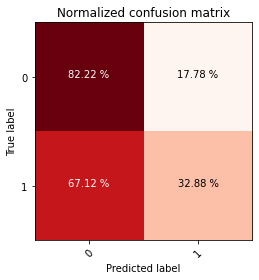

In [80]:
# разделим выборку на обучающую и тестовую(валидационную, проверочную, отложенная)
x_train, x_test, y_train, y_test = train_test_split(feat, target, test_size=0.1, random_state=42)

# обучим модель дерева на обучающей выборке и предскажем на отложенной:
model = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
print('Общее число совпадений', round(accuracy_score(y_test, y_pred), 3))
print('Полнота охвата класса 1:', round(recall_score(y_test, y_pred), 3))
print('Точность:', round(precision_score(y_test, y_pred), 3))
print('ROC_AUC:', round(roc_auc_score(y_test, y_pred_proba), 3))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)

In [81]:
onehot_enc1 = OneHotEncoder()
X_carrier = onehot_enc1.fit_transform(feat[['carrier']])
X_carrier = pd.DataFrame(X_carrier.toarray().astype(np.uint8),
                         columns=['car{}'.format(k) for k in range(len(np.unique(feat['carrier'].values)))])

onehot_enc1 = OneHotEncoder()
X_month = onehot_enc1.fit_transform(feat[['month']])
X_month = pd.DataFrame(X_month.toarray().astype(np.uint8),
                         columns=['m{}'.format(k) for k in range(len(np.unique(feat['month'].values)))])

onehot_enc1 = OneHotEncoder()
X_day_week = onehot_enc1.fit_transform(feat[['day_week']])
X_day_week = pd.DataFrame(X_day_week.toarray().astype(np.uint8),
                         columns=['dw{}'.format(k) for k in range(len(np.unique(feat['day_week'].values)))])

onehot_enc1 = OneHotEncoder()
X_ab = onehot_enc1.fit_transform(feat[['a-b']])
X_ab = pd.DataFrame(X_ab.toarray().astype(np.uint8),
                         columns=['abr{}'.format(k) for k in range(len(np.unique(feat['a-b'].values)))])
# X_ab не будем использовать, эта DF слишком широкая получается

print(X_month.head())
print(X_day_week.head())
print(X_carrier.head())

   m0  m1  m2  m3  m4  m5  m6  m7  m8  m9  m10  m11
0   0   0   0   0   0   0   0   1   0   0    0    0
1   0   0   0   1   0   0   0   0   0   0    0    0
2   0   0   0   0   0   0   0   0   1   0    0    0
3   0   0   0   0   0   0   0   0   0   0    1    0
4   0   0   0   0   0   0   0   0   0   1    0    0
   dw0  dw1  dw2  dw3  dw4  dw5  dw6
0    0    0    0    0    0    0    1
1    0    0    1    0    0    0    0
2    0    0    0    0    1    0    0
3    0    0    0    0    0    1    0
4    0    0    0    0    0    1    0
   car0  car1  car2  car3  car4  car5  car6  car7  car8  car9  ...  car12  \
0     1     0     0     0     0     0     0     0     0     0  ...      0   
1     0     0     0     0     0     0     0     0     0     0  ...      0   
2     0     0     0     0     0     0     0     0     0     0  ...      0   
3     0     0     0     0     0     0     0     0     0     0  ...      0   
4     0     0     0     0     0     0     0     0     0     0  ...      0   

   

In [82]:
feat = feat.drop(['carrier', 'month', 'day_week'], axis=1) # удаляем столбцы, которые мы учитываем через OneHot

feat = pd.concat([feat,X_carrier,X_month,X_day_week], axis=1)
feat.head()

,nday,hour,sin_hour,cos_hour,minute,sin_min,cos_min,distance,a,b,...,m9,m10,m11,dw0,dw1,dw2,dw3,dw4,dw5,dw6
0,21,19,-0.965926,2.588190e-01,34,-0.406737,-9.135455e-01,732,18,78,...,0,0,0,0,0,0,0,0,0,1
1,20,15,-0.707107,-7.071068e-01,48,-0.951057,3.090170e-01,834,217,171,...,0,0,0,0,0,1,0,0,0,0
2,2,14,-0.500000,-8.660254e-01,22,0.743145,-6.691306e-01,416,228,59,...,0,0,0,0,0,0,0,1,0,0
3,25,10,0.500000,-8.660254e-01,15,1.000000,2.832769e-16,872,78,175,...,0,1,0,0,0,0,0,0,1,0
4,7,18,-1.000000,-1.836970e-16,28,0.207912,-9.781476e-01,423,174,199,...,1,0,0,0,0,0,0,0,1,0


In [87]:
#ss = StandardScaler()
#feat['nday'] = ss.fit_transform(feat[['nday']])
#feat['hour'] = ss.fit_transform(feat[['hour']])
#feat['minute'] = ss.fit_transform(feat[['minute']])
#feat['distance'] = ss.fit_transform(feat[['distance']])

## Models: DT

Общее число совпадений 0.736
Полнота охвата класса 1: 0.332
Точность: 0.32
ROC_AUC: 0.582


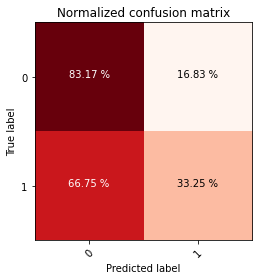

In [101]:
# разделим выборку на обучающую и тестовую(валидационную, проверочную, отложенная)
x_train, x_test, y_train, y_test = train_test_split(feat, target, test_size=0.1, random_state=42)

# обучим модель дерева на обучающей выборке и предскажем на отложенной:
model = DecisionTreeClassifier(max_depth=140, min_samples_split=2, criterion='entropy')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
print('Общее число совпадений', round(accuracy_score(y_test, y_pred), 3))
print('Полнота охвата класса 1:', round(recall_score(y_test, y_pred), 3))
print('Точность:', round(precision_score(y_test, y_pred), 3))
print('ROC_AUC:', round(roc_auc_score(y_test, y_pred_proba), 3))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)

## Models: Бустинг

In [112]:
from catboost import CatBoostClassifier

In [114]:
path_to_file = 'flight_delays.csv'
df = pd.read_csv(path_to_file)


feat = pd.DataFrame(index=df.index)
feat['month'] = df['Month'].apply(lambda x: int(x[2:]))
feat['nday'] = df['DayofMonth'].apply(lambda x: int(x[2:]))
feat['day_week'] = df['DayOfWeek'].apply(lambda x: int(x[2:]))

feat['hour'] =  df['DepTime']//100
feat.loc[feat['hour'] == 24, 'hour'] = 0
feat.loc[feat['hour'] == 25, 'hour'] = 1
feat['sin_hour'] = np.sin(2*np.pi*feat['hour']/24)
feat['cos_hour'] = np.cos(2*np.pi*feat['hour']/24)

feat['minute'] =  df['DepTime']%100
feat['sin_min'] = np.sin(2*np.pi*feat['minute']/60)
feat['cos_min'] = np.cos(2*np.pi*feat['minute']/60)

feat['distance'] = df['Distance']
feat['carrier'] = df['UniqueCarrier']
feat['a'] = df['Origin']
feat['b'] = df['Dest']
#feat['a-b'] = df['Origin'] + '-' + df['Dest'] # направление

feat.head()

,month,nday,day_week,hour,sin_hour,cos_hour,minute,sin_min,cos_min,distance,carrier,a,b
0,8,21,7,19,-0.965926,2.588190e-01,34,-0.406737,-9.135455e-01,732,AA,ATL,DFW
1,4,20,3,15,-0.707107,-7.071068e-01,48,-0.951057,3.090170e-01,834,US,PIT,MCO
2,9,2,5,14,-0.500000,-8.660254e-01,22,0.743145,-6.691306e-01,416,XE,RDU,CLE
3,11,25,6,10,0.500000,-8.660254e-01,15,1.000000,2.832769e-16,872,OO,DEN,MEM
4,10,7,6,18,-1.000000,-1.836970e-16,28,0.207912,-9.781476e-01,423,WN,MDW,OMA


In [ ]:
%%time

# разделим выборку на обучающую и тестовую(валидационную, проверочную, отложенная)
x_train, x_test, y_train, y_test = train_test_split(feat, target, test_size=0.1, random_state=42)

model = CatBoostClassifier(n_estimators=500, random_state=42)
model.fit(x_train, y_train, cat_features = [0,1,2,3,10,11,12], verbose=False)
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:,1]

Общее число совпадений 0.836
Полнота охвата класса 1: 0.325
Точность: 0.644
ROC_AUC: 0.81


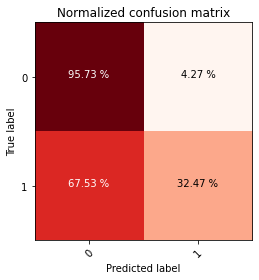

In [116]:
# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
# n_estimators=500
print('Общее число совпадений', round(accuracy_score(y_test, y_pred), 3))
print('Полнота охвата класса 1:', round(recall_score(y_test, y_pred), 3))
print('Точность:', round(precision_score(y_test, y_pred), 3))
print('ROC_AUC:', round(roc_auc_score(y_test, y_pred_proba), 3))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)